# Cat and Dog Classifier

## The Project
In this project we'll use `Keras`, a Neural Network API that runs on top of `TensorFlow` or `Theano`, to build a Image classifier.

## The Data
We'll classify images from cats and dogs. The dataset can be found on [Kragger](https://www.kaggle.com/c/dogs-vs-cats/data).

### Folder structure
To train our model, we're gonna use only a little bit of the kraggle data. The entire dataset is around 15.000 images and we'll use only 1.400 (1.000 for training and 400 for validation).

That's the folder structure:
```
data/
    train/
        dogs/ ### 1000 pictures
            dog.0.jpg
            dog.1.jpg
            ...
        cats/ ### 1000 pictures
            cat.0.jpg
            cat.1.jpg
            ...
    validation/
        dogs/ ### 400 pictures
            dog.1000.jpg
            dog.1001.jpg
            ...
        cats/ ### 400 pictures
            cat.1000.jpg
            cat.1001.jpg
```

## Training our first model
We'll train our first model and check what results we can get.

In [1]:
!KERAS_BACKEND=tensorflow # use tensorflow as backend

In [53]:
# import dependencies
import os
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import backend as K
from keras import applications

In [3]:
#Image Dimensions
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

We're creating a `Sequential` Neural Network for this project.

In [13]:
# Check if we're using tensorflow or theano as backend
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Init our sequential model
model = Sequential()

# Add a convolution layer with relu activation
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolution layer with relu activation
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolution layer with relu activation
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flatten layer that converts our 3D feature maps to 1D feature vectors
model.add(Flatten())
# Add a dense layer
model.add(Dense(64))
# relu activation
model.add(Activation('relu'))
# Add a dropout layer
model.add(Dropout(0.5))
# Another dense layer
model.add(Dense(1))
# sigmoid activation
model.add(Activation('sigmoid'))

In [14]:
# Compiles our model with loss, optimizer and metrics functions
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
# Defines our batch_size
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [16]:
# hyperparameters
epochs = 50
steps_per_epoch = 2000
validation_steps = 800

In [18]:
# Training the model
model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps // batch_size)

Epoch 1/50
125/125 [==============================] - 8s - loss: 0.7069 - acc: 0.5035 - val_loss: 0.6921 - val_acc: 0.6262
Epoch 2/50
125/125 [==============================] - 7s - loss: 0.6892 - acc: 0.5570 - val_loss: 0.6864 - val_acc: 0.5250
Epoch 3/50
125/125 [==============================] - 7s - loss: 0.6712 - acc: 0.6115 - val_loss: 0.6543 - val_acc: 0.5737
Epoch 4/50
125/125 [==============================] - 7s - loss: 0.6437 - acc: 0.6460 - val_loss: 0.6092 - val_acc: 0.6800
Epoch 5/50
125/125 [==============================] - 7s - loss: 0.6005 - acc: 0.6800 - val_loss: 0.6042 - val_acc: 0.6787
Epoch 6/50
125/125 [==============================] - 7s - loss: 0.6023 - acc: 0.6830 - val_loss: 0.6108 - val_acc: 0.6562
Epoch 7/50
125/125 [==============================] - 7s - loss: 0.5948 - acc: 0.6895 - val_loss: 0.5706 - val_acc: 0.7013
Epoch 8/50
125/125 [==============================] - 7s - loss: 0.5834 - acc: 0.6965 - val_loss: 0.5530 - val_acc: 0.7350
Epoch 9/50
125/1

In [19]:
# Saving our weights for any future use
model.save_weights('models/basic_cnn_50_epochs.h5')

After some traning we reach 79% of validation accuracy. This is really great, but we can do it better.

## Improving our model with pre-trained data

Traning over a previous trained model can reach better results, let's see below:

In [96]:
# Defines our data generator
datagen = ImageDataGenerator(rescale=1. / 255)

model = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 2000 // batch_size)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

# same thing below with validation data
validation_generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(validation_generator, 800 // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [97]:
# Loading our data

train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 400 + [1] * 400)

In [100]:
# Again, a sequential model
model_2 = Sequential()
model_2.add(Flatten(input_shape=train_data.shape[1:]))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 0s - loss: 0.7667 - acc: 0.7635 - val_loss: 0.2549 - val_acc: 0.9025
Epoch 2/50
2000/2000 [==============================] - 0s - loss: 0.3758 - acc: 0.8510 - val_loss: 0.4589 - val_acc: 0.8075
Epoch 3/50
2000/2000 [==============================] - 0s - loss: 0.2882 - acc: 0.8840 - val_loss: 0.2610 - val_acc: 0.9025
Epoch 4/50
2000/2000 [==============================] - 0s - loss: 0.2360 - acc: 0.9050 - val_loss: 0.3144 - val_acc: 0.8675
Epoch 5/50
2000/2000 [==============================] - 0s - loss: 0.2230 - acc: 0.9080 - val_loss: 0.3290 - val_acc: 0.8862
Epoch 6/50
2000/2000 [==============================] - 0s - loss: 0.2004 - acc: 0.9165 - val_loss: 0.2946 - val_acc: 0.8988
Epoch 7/50
2000/2000 [==============================] - 0s - loss: 0.1785 - acc: 0.9385 - val_loss: 0.2865 - val_acc: 0.9062
Epoch 8/50
2000/2000 [==============================] - 0s - loss: 0.1714 - ac

In [43]:
# Saving our weights for future use
model_2.save_weights('models/bottleneck_fc_model.h5')

Well, after traning over pre-trained data we can reach 90% accuracy, this is really great!

## Fine-tuning our Neural Net with a pre-trained network
Let's use the VGG16 pre-trained network from imagenet and see if we can reach better results.

In [120]:
# Loading our weights
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'models/bottleneck_fc_model.h5'

# Verifying backend again
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Creating our vgg16 base model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Our top model will be added after vgg16 layers
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# loading our pre-trained weights
top_model.load_weights(top_model_weights_path)

# building our final model
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# blocking pre-trained layer to no be trainable
for layer in model.layers[:25]:
    layer.trainable = False

# compile our model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [121]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [122]:
# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps // batch_size)

Epoch 1/50
125/125 [==============================] - 15s - loss: 0.5410 - acc: 0.9230 - val_loss: 0.8793 - val_acc: 0.8950
Epoch 2/50
125/125 [==============================] - 14s - loss: 0.5668 - acc: 0.9160 - val_loss: 0.9978 - val_acc: 0.8875
Epoch 3/50
125/125 [==============================] - 14s - loss: 0.5743 - acc: 0.9195 - val_loss: 0.8057 - val_acc: 0.8925
Epoch 4/50
125/125 [==============================] - 15s - loss: 0.5166 - acc: 0.9260 - val_loss: 0.9559 - val_acc: 0.8925
Epoch 5/50
125/125 [==============================] - 15s - loss: 0.5616 - acc: 0.9165 - val_loss: 0.7748 - val_acc: 0.9038
Epoch 6/50
125/125 [==============================] - 15s - loss: 0.5862 - acc: 0.9175 - val_loss: 0.8793 - val_acc: 0.8950
Epoch 7/50
125/125 [==============================] - 15s - loss: 0.5214 - acc: 0.9220 - val_loss: 0.8614 - val_acc: 0.8988
Epoch 8/50
125/125 [==============================] - 15s - loss: 0.5264 - acc: 0.9195 - val_loss: 0.7949 - val_acc: 0.9012
Epoch 9/

We reached about 91% of validation accuracy and amost 93% training accuracy, this is really great!

## Testing our model

Let's test our model in some pictures.

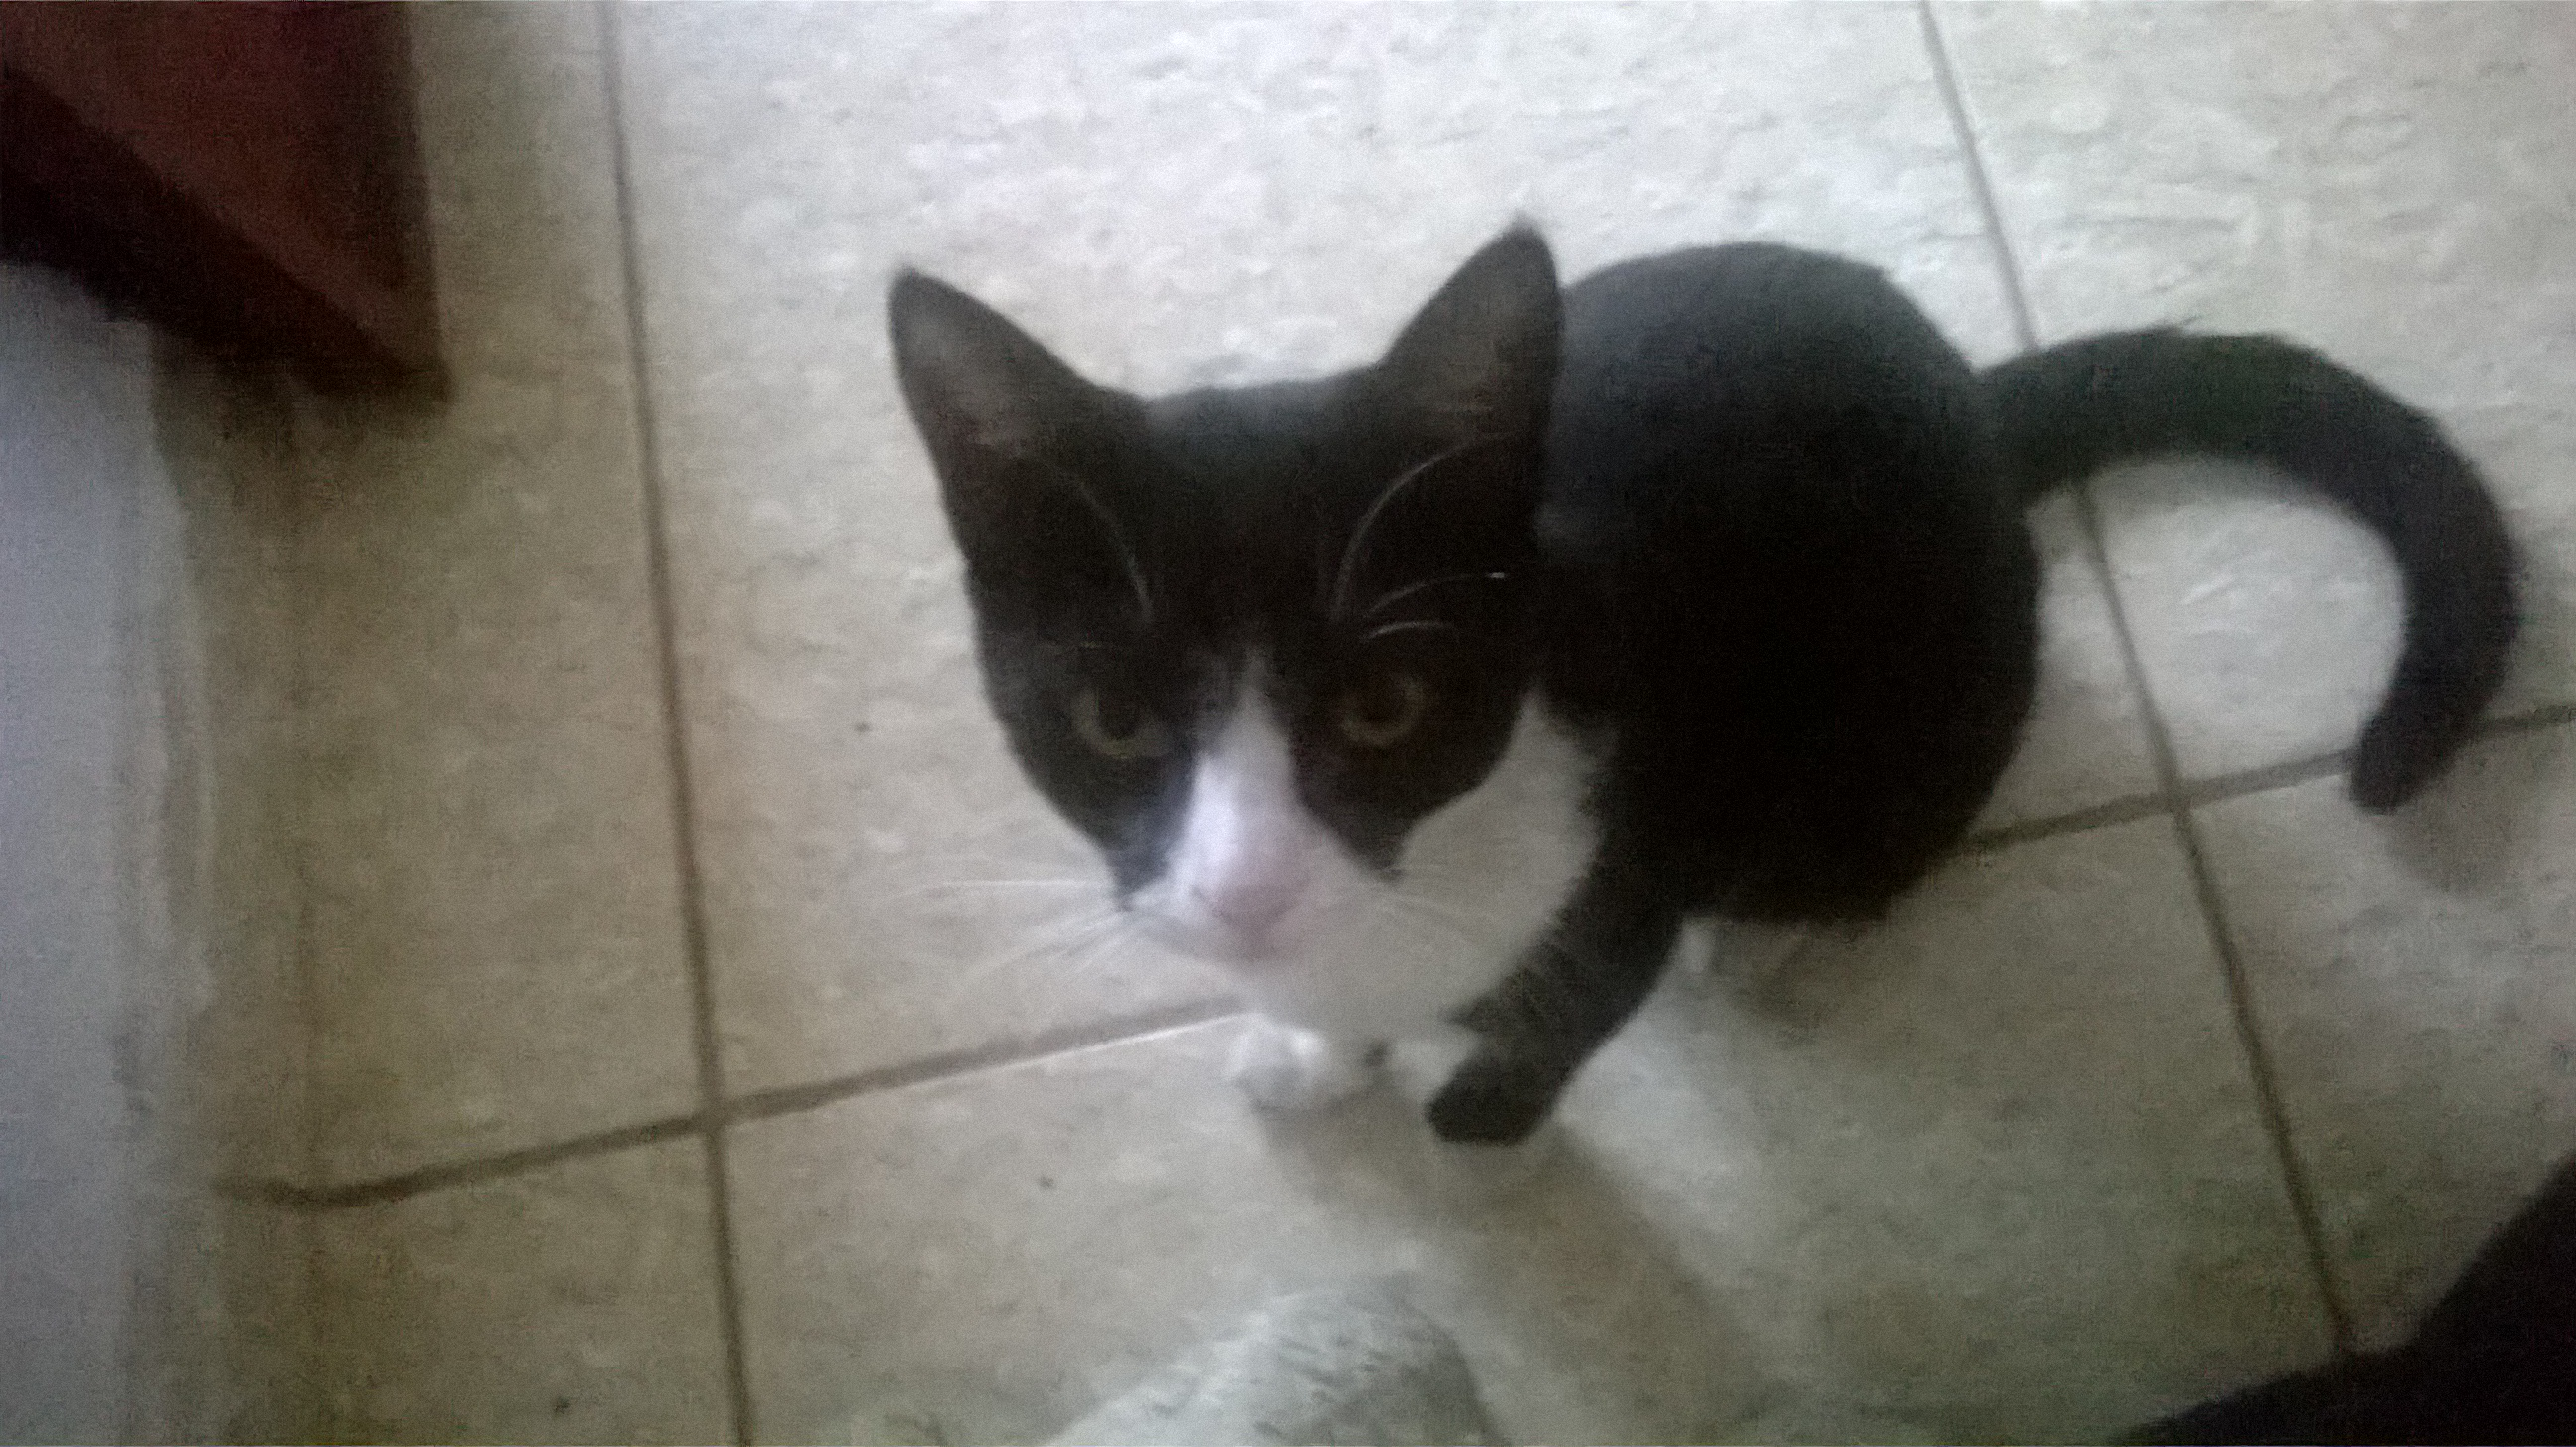

In [126]:
from IPython.display import Image
Image("data/test/nina.jpg")

This is my kitten Nina, let's test it's picture.

In [138]:
from keras.preprocessing import image
img = image.load_img('data/test/nina_150x150.jpg', target_size=(img_width, img_height))

nina = image.img_to_array(img)
nina = np.expand_dims(nina, axis=0)

images = np.vstack([nina])
classes = model.predict(images, batch_size=batch_size)
for item in classes:
    if item[0] == 0.:
        print('Cat')
    else:
        print('Dog')

Cat


Let's try with my ~~girl~~friend's dog. Dara

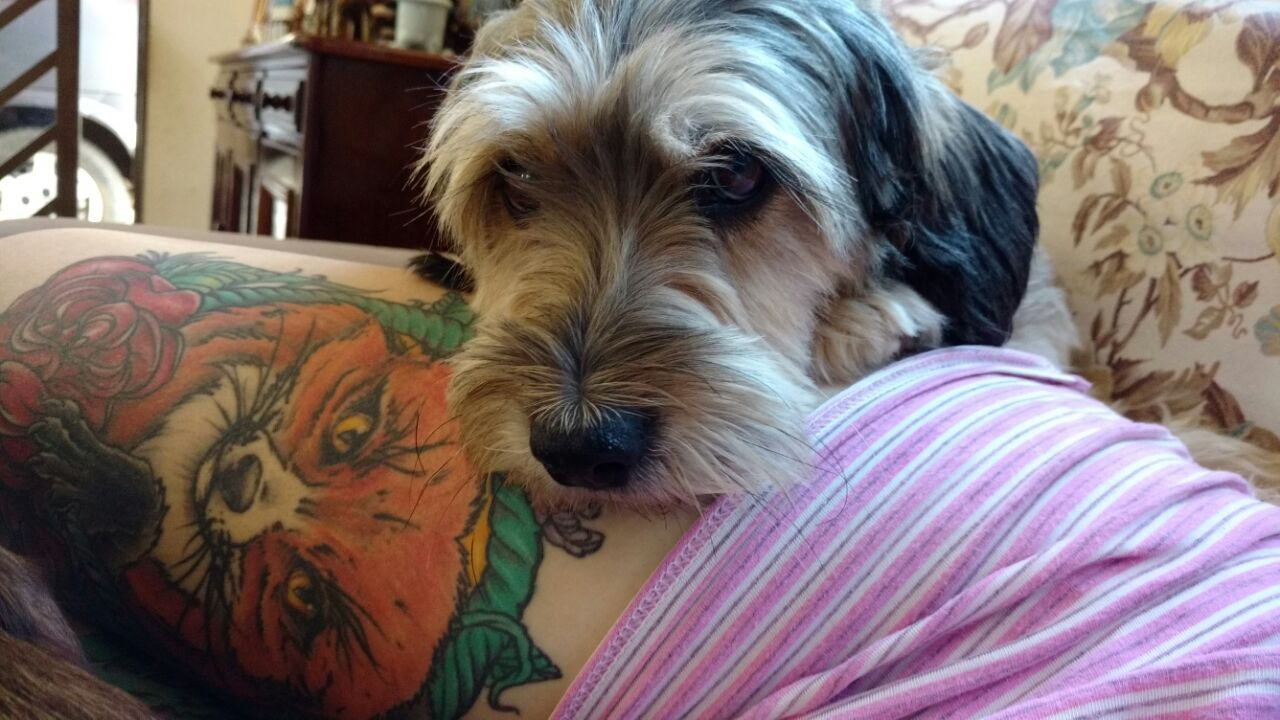

In [140]:
from IPython.display import Image
Image("data/test/dara.jpg")

In [139]:
img2 = image.load_img('data/test/dara_150x150.jpg', target_size=(img_width, img_height))
dara = image.img_to_array(img2)
dara = np.expand_dims(dara, axis=0)

images = np.vstack([dara])
classes = model.predict(images, batch_size=batch_size)
for item in classes:
    if item[0] == 0.:
        print('Cat')
    else:
        print('Dog')

Dog


Well, that's it! We build an image classifier with 90% precision easily.

## Concepts used int this example:
+ Convolutional Neural Networks
+ Max Pooling

Try to google and study more about these concepts :D
